# mini5. 중간 프로젝트
## 5팀 : 심전근 뇌졸증 진단 프로그램
1. Heart Failure Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction   
데이터 이름 : 'Healthcare-Stroke.csv'   
데이터 포맷 : (row, col)   
메타데이터 :   
    - id : 고유 식별자
    - gender : 환자의 성별
    - age : 환자의 연령
    - hypertension : 환자가 고혈압이 아닌 경우 0, 고혈압인 경우 1
    - heart_parament : 환자가 심장 질환이 없는 경우 0, 환자가 심장 질환이 있는 경우 1
    - ever_married : 결혼한 적이 있는가 "아니오" 또는 "예"
    - work_type : "Children", "Govt_jov", "Never_worked", "Private" 또는 "Self-employed"
    - Residence_type : "Rural" or "Urban”
    - avg_glucose_level : 혈중 평균 포도당 수준
    - bmi : 체질량지수
    - smoking_status : "formerly smoked", "never smoked", "smokes" or "Unknown"
    - stroke : 뇌졸중이 있는 경우 1, 뇌졸중이 아닌 경우 0
    - 참고 : smoking_status의 Unknown은 이 환자에 대한 정보를 사용할 수 없음을 의미한다. 
   

2. Stroke Prediction Dataset   
데이터 출처: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset   
데이터 이름 : 'Healthcare-Heart.csv'   
데이터 포맷 : (row, col)   
메타데이터 :  
    - Age : 환자의 나이
    - Sex : 환자의 성별
    - ChestPainType : 흉통 유형
        TA : 일반 협심증,  ATA : 비정형 협심증,  NAP : 비혈관 통증,  ASY : 무증상
    - RestingBP : 휴면혈압[mmHg]
    - Cholesterol : 혈청 콜레스테롤 [mm/dl]
    - FastingBS : 금식혈당
        1 : 금식인 경우BS > 120 mg/dl
        0 : 그렇지 않은 경우
    - RestingECG : 심전도 결과
        정상 : 정상
        ST : ST-T파 이상(T파 반전 및/또는 ST 상승 또는 0.05mV 이상 하강)
        LVH : Estes의 기준에 의해 발생가능하거나 확실한 좌심실 비대
    - MaxHR : 달성된 최대 심박수 (60 ~ 202)
    - ExerciseAngina : 운동으로 인한 협심증 Y/N
    - Oldpeak : 이전 피크 = ST [저하 상태에서 측정된 숫자 값]
    - ST_Slope : 피크 연습 ST 세그먼트의 기울기 [위: 상향, 평탄: 하향: 하향]
    - HeartDisease : 1 심장 질환,  0 정상 

## 0. 환경설정

### 라이브러리 호출

In [1]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from imblearn.over_sampling import SMOTE

# 한글 폰트 패치.
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False  

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# ggplot style skima
plt.style.use("ggplot")

# seaborn plot style definition
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn Module Import
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

from xgboost import XGBClassifier, plot_importance

### 시각화 한글 폰트 설정

In [2]:
import platform

def get_font_family():
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

%config InlineBackend.figure_format = 'retina'

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

get_font_family()

'Malgun Gothic'

### 그래프 색상 그라데이션 설정

In [3]:
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,256),0).T
    ax = bars[0].axes 
    lim = ax.get_xlim()+ax.get_ylim() 
    for bar in bars:
        bar.set_facecolor("none") 
        x,y = bar.get_xy() 
        w, h = bar.get_width(), bar.get_height() 
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) 
    ax.axis(lim)

### 사용자 함수 정의

In [4]:
# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#     return [acc, pre, rec, f1]

# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()
    
# 상관관계 히트맵 함수
def corr_plot(data, cmap, width, height, title):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr))

    plt.figure(figsize=(width, height))
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, vmin=-1, vmax=1, fmt=".2f")
    plt.title(title, fontsize=20)
    plt.show()
    

# 혼동행렬 시각화 함수
def plot_confusion_matrix(cm, class_names, figsize=(8, 8)):
    cm = cm.numpy()
    figure = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure    

## 1. 데이터 로드
### Healthcare-Stroke.csv (row, col)

In [5]:
# Data Load
def data_load(path, file):
    df = pd.read_csv(f"{path}{file}", sep=",")
    return df

path = 'data/'
file = 'Healthcare-Stroke.csv'

In [6]:
df = data_load(path, file)
print('df.shape :',df.shape)
df.head()

df.shape : (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [8]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
# data describe
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 2. 데이터 전처리 & EDA

In [10]:
# 의미없는 'ID'특성 제거
df = df[df.columns.difference(['id'])]
df.shape

(5110, 11)

### LabelEncoding

In [11]:
# LabelEncoding
cat_list = ['gender','ever_married','work_type','Residence_type','smoking_status']
for cat in cat_list:
    l_encoder = LabelEncoder()
    l_encoder.fit(df[cat])
    labels = l_encoder.transform(df[cat])
    df[cat] = labels

    print(cat,':',l_encoder.classes_)
    print(cat,'encoded :',np.unique(labels),'\n')

gender : ['Female' 'Male' 'Other']
gender encoded : [0 1 2] 

ever_married : ['No' 'Yes']
ever_married encoded : [0 1] 

work_type : ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
work_type encoded : [0 1 2 3 4] 

Residence_type : ['Rural' 'Urban']
Residence_type encoded : [0 1] 

smoking_status : ['Unknown' 'formerly smoked' 'never smoked' 'smokes']
smoking_status encoded : [0 1 2 3] 



### MissingValue Processing

In [12]:
# gender = 2로 표기되어 있는 사람은 성별을 알 수 없으므로 제거.
df[df['gender'] == 2]

,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
3116,0,26.0,143.33,22.4,0,2,0,0,1,0,2


In [13]:
df.drop(index = df[df['gender'] == 2].index, inplace=True)

In [14]:
# bmi 칼럼의 nan값들을 평균값으로 대치
df['bmi'].fillna(df['bmi'].mean(), axis=0,inplace=True)

### Outlier Processing

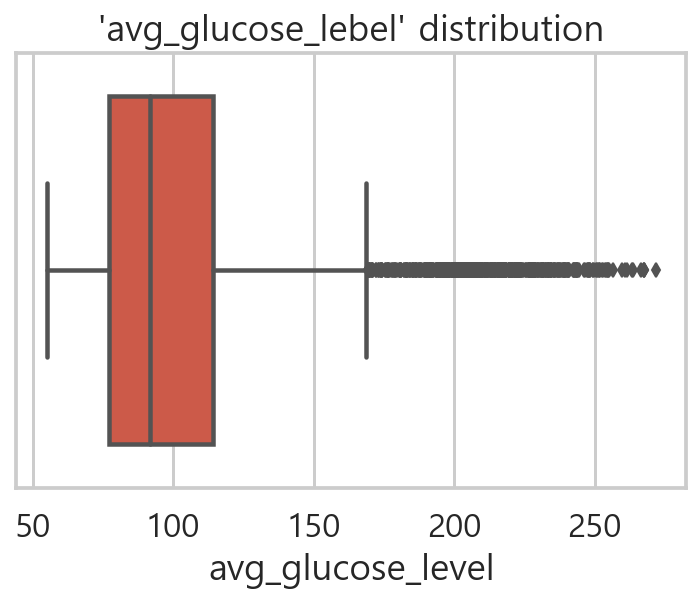

In [15]:
plt.title("'avg_glucose_lebel' distribution")
sns.boxplot(df['avg_glucose_level'])
plt.show()

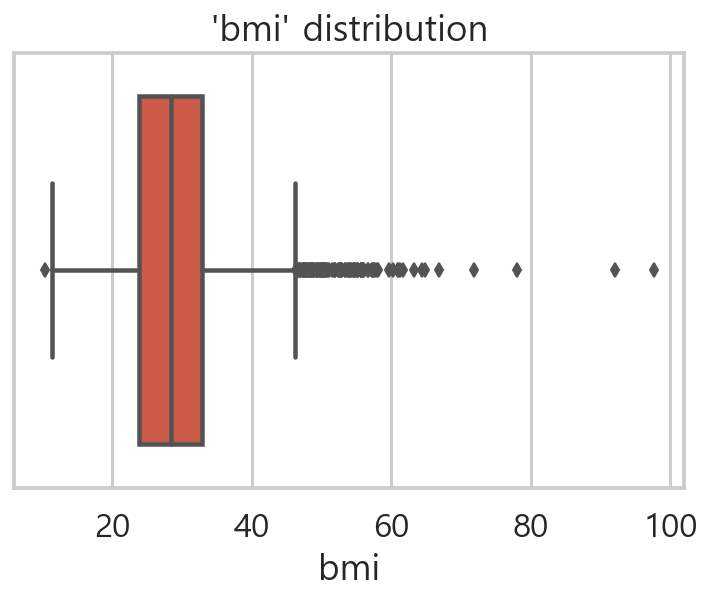

In [16]:
plt.title("'bmi' distribution")
sns.boxplot(df['bmi'])
plt.show()

In [17]:
# bmi 칼럼의 상위 4 개의 이상치에 대해 최대값으로 대치
df.loc[df['bmi'].sort_values(ascending=False)[:4].index,'bmi'] = df['bmi'].sort_values(ascending=False)[:5].values[-1]

### StandardScaler, Log Transformation

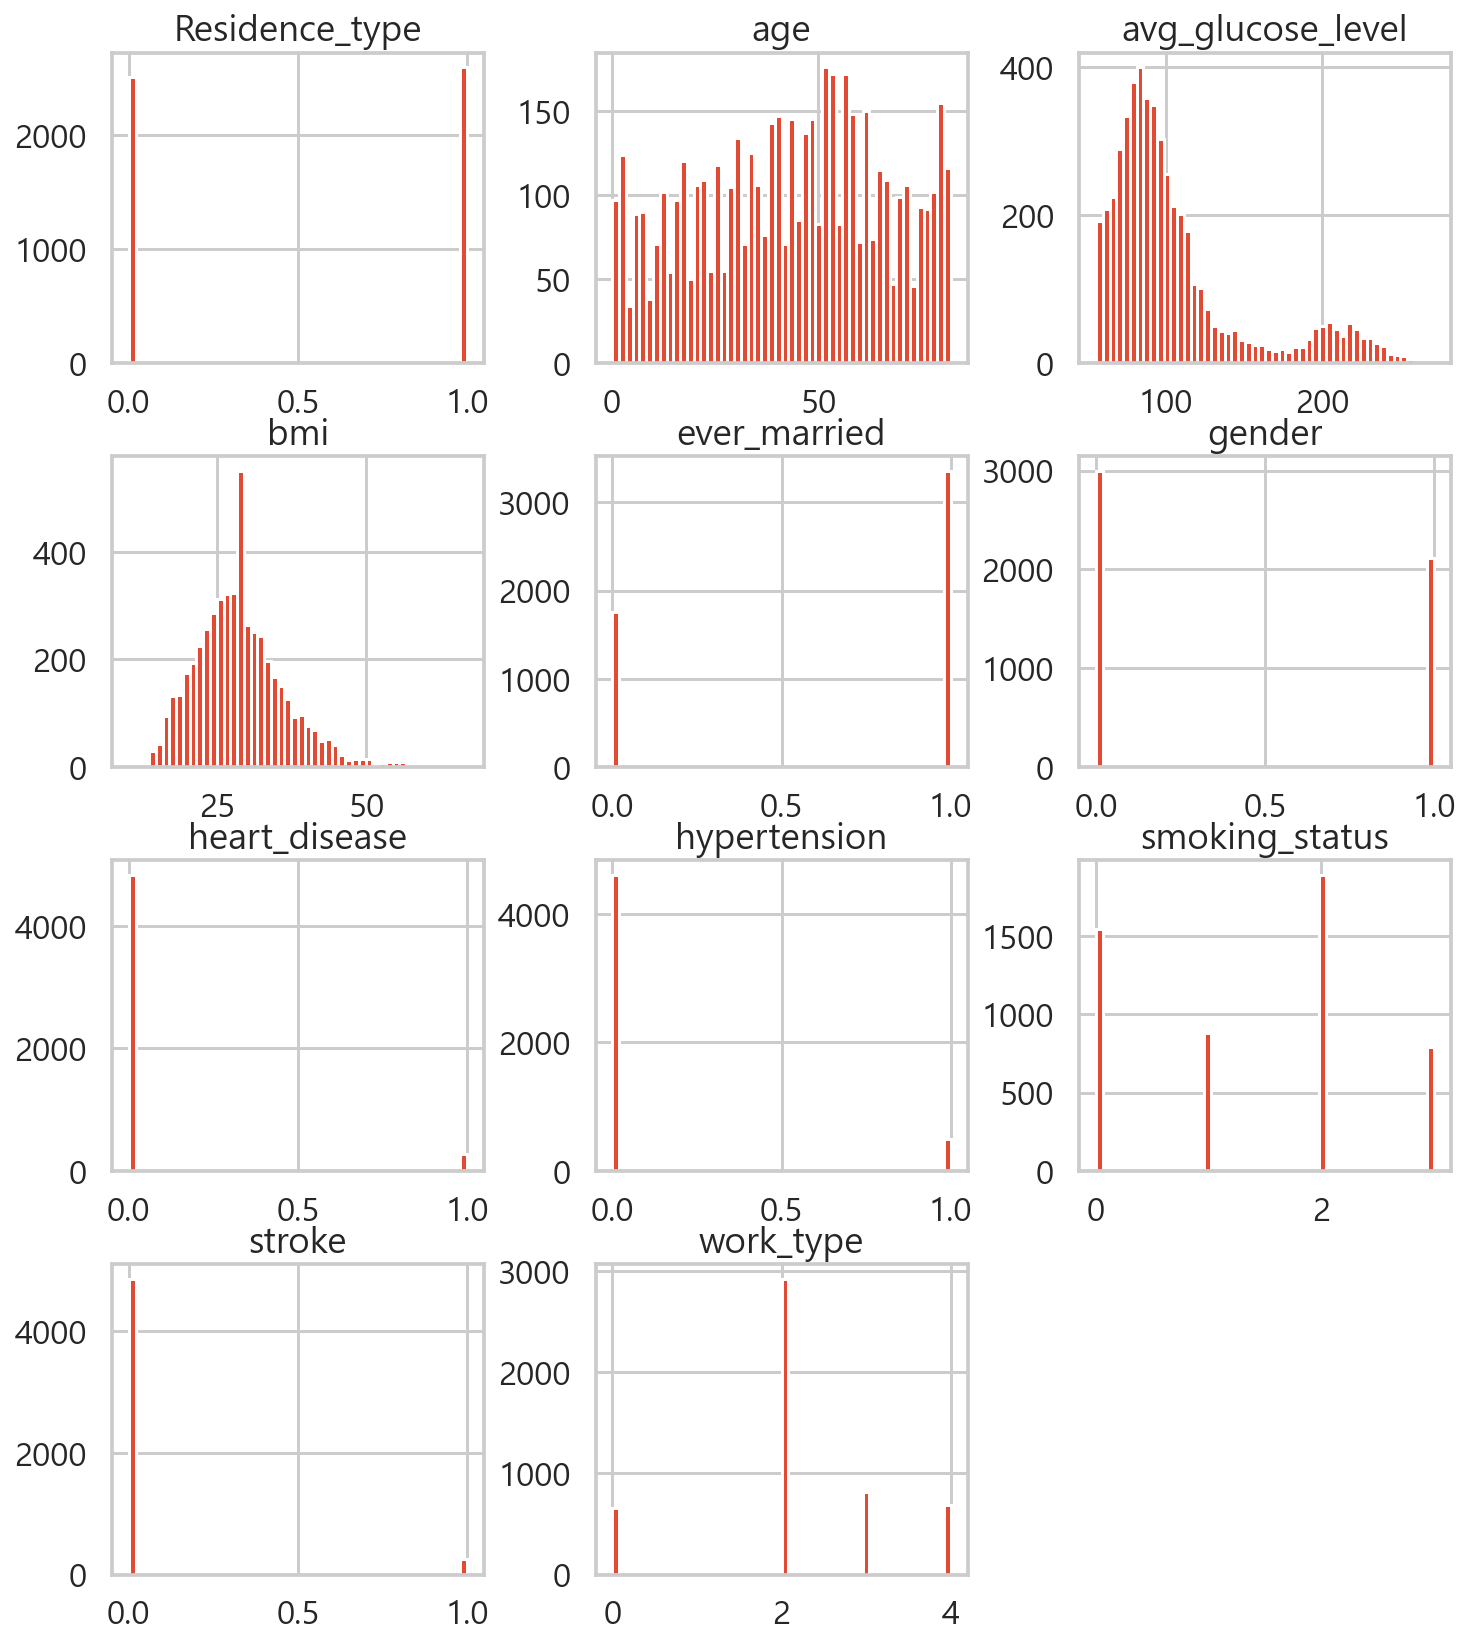

In [18]:
# Histogram
df.hist(figsize=(12,14),bins=50)
plt.show()

In [19]:
# 로그 변환 to ['bmi', 'avg_glucose_level']
df[['bmi', 'avg_glucose_level']] = np.log1p(df[['bmi', 'avg_glucose_level']])

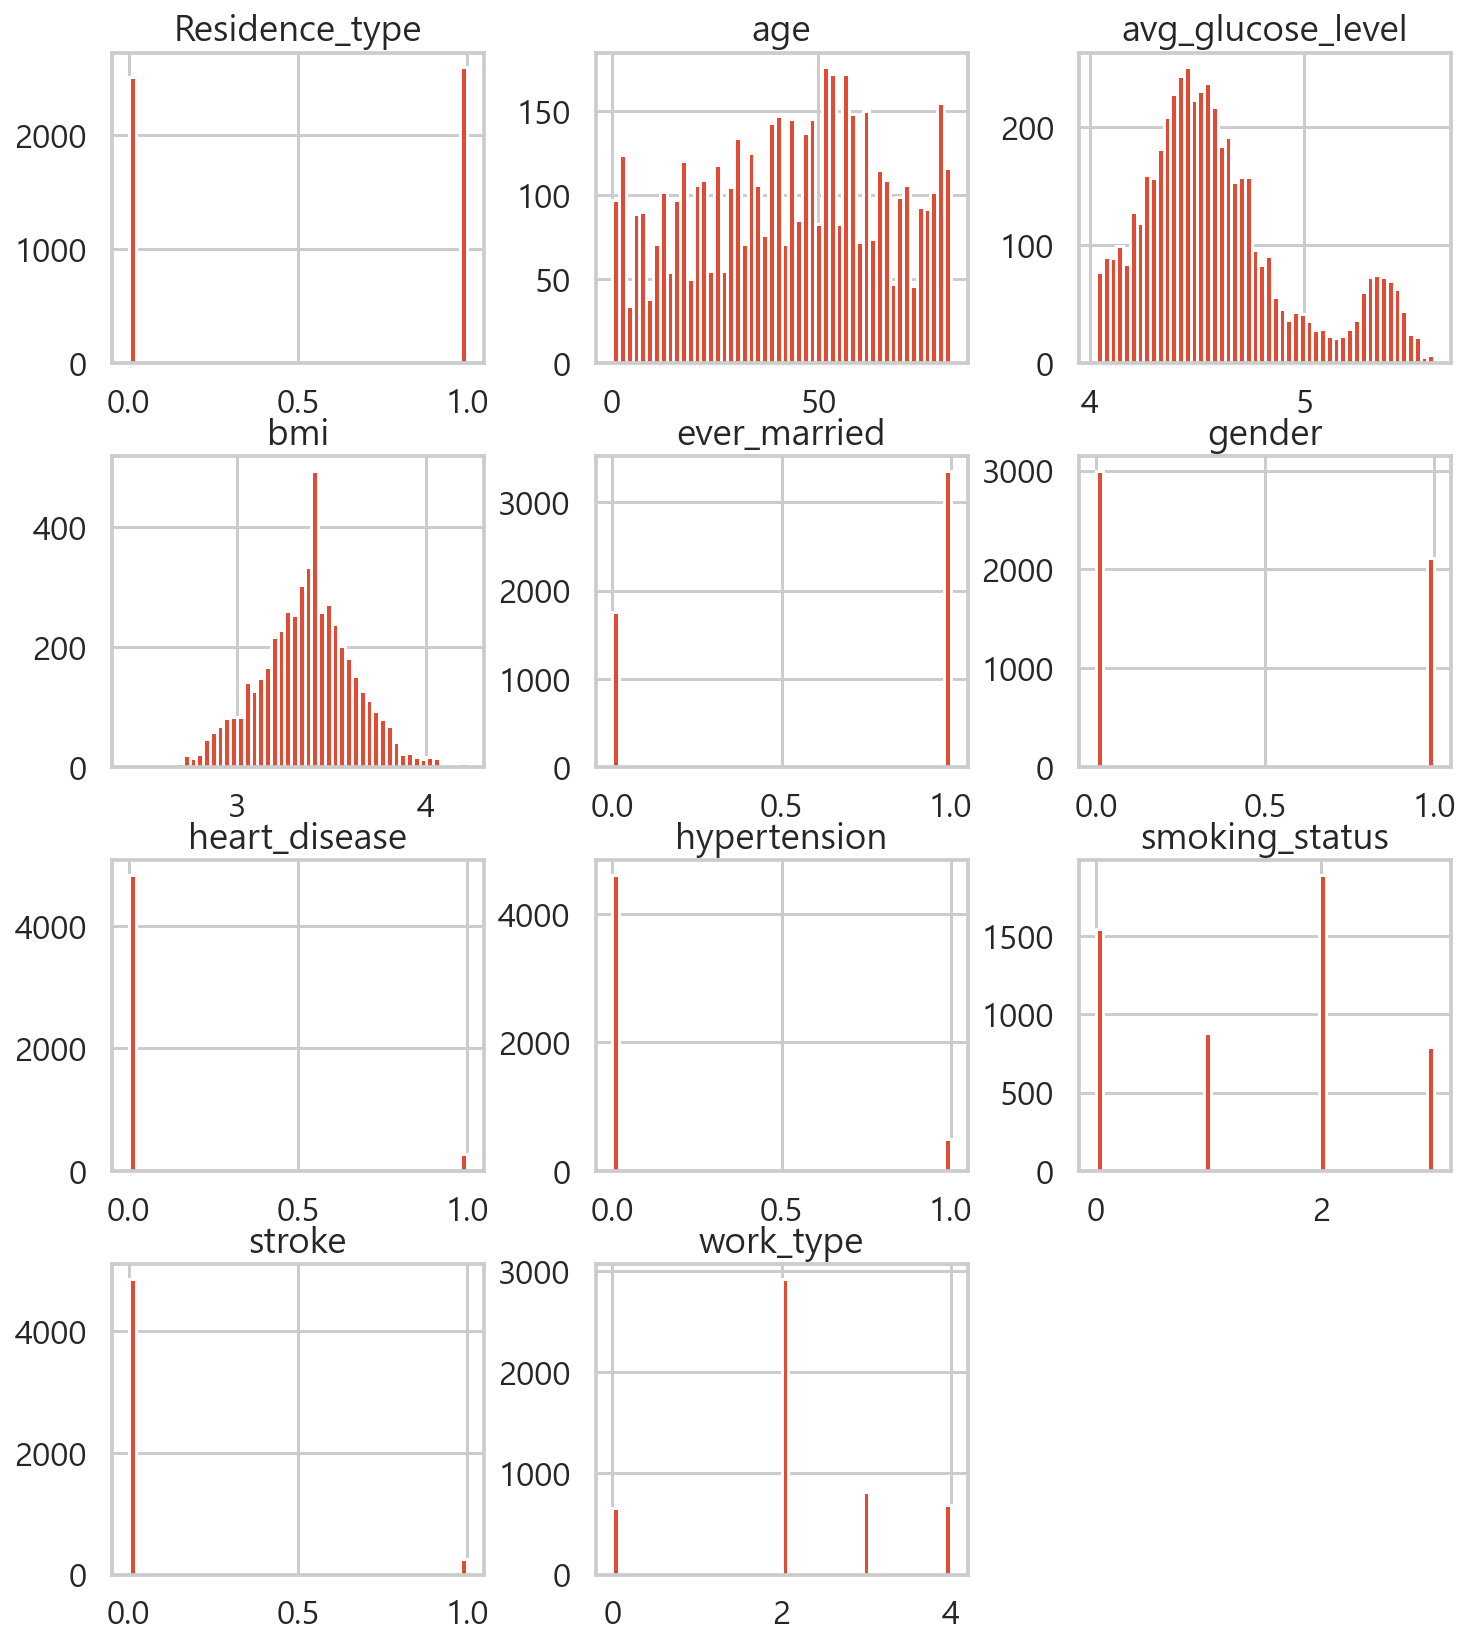

In [20]:
# Histogram
df.hist(figsize=(12,14),bins=50)
plt.show()

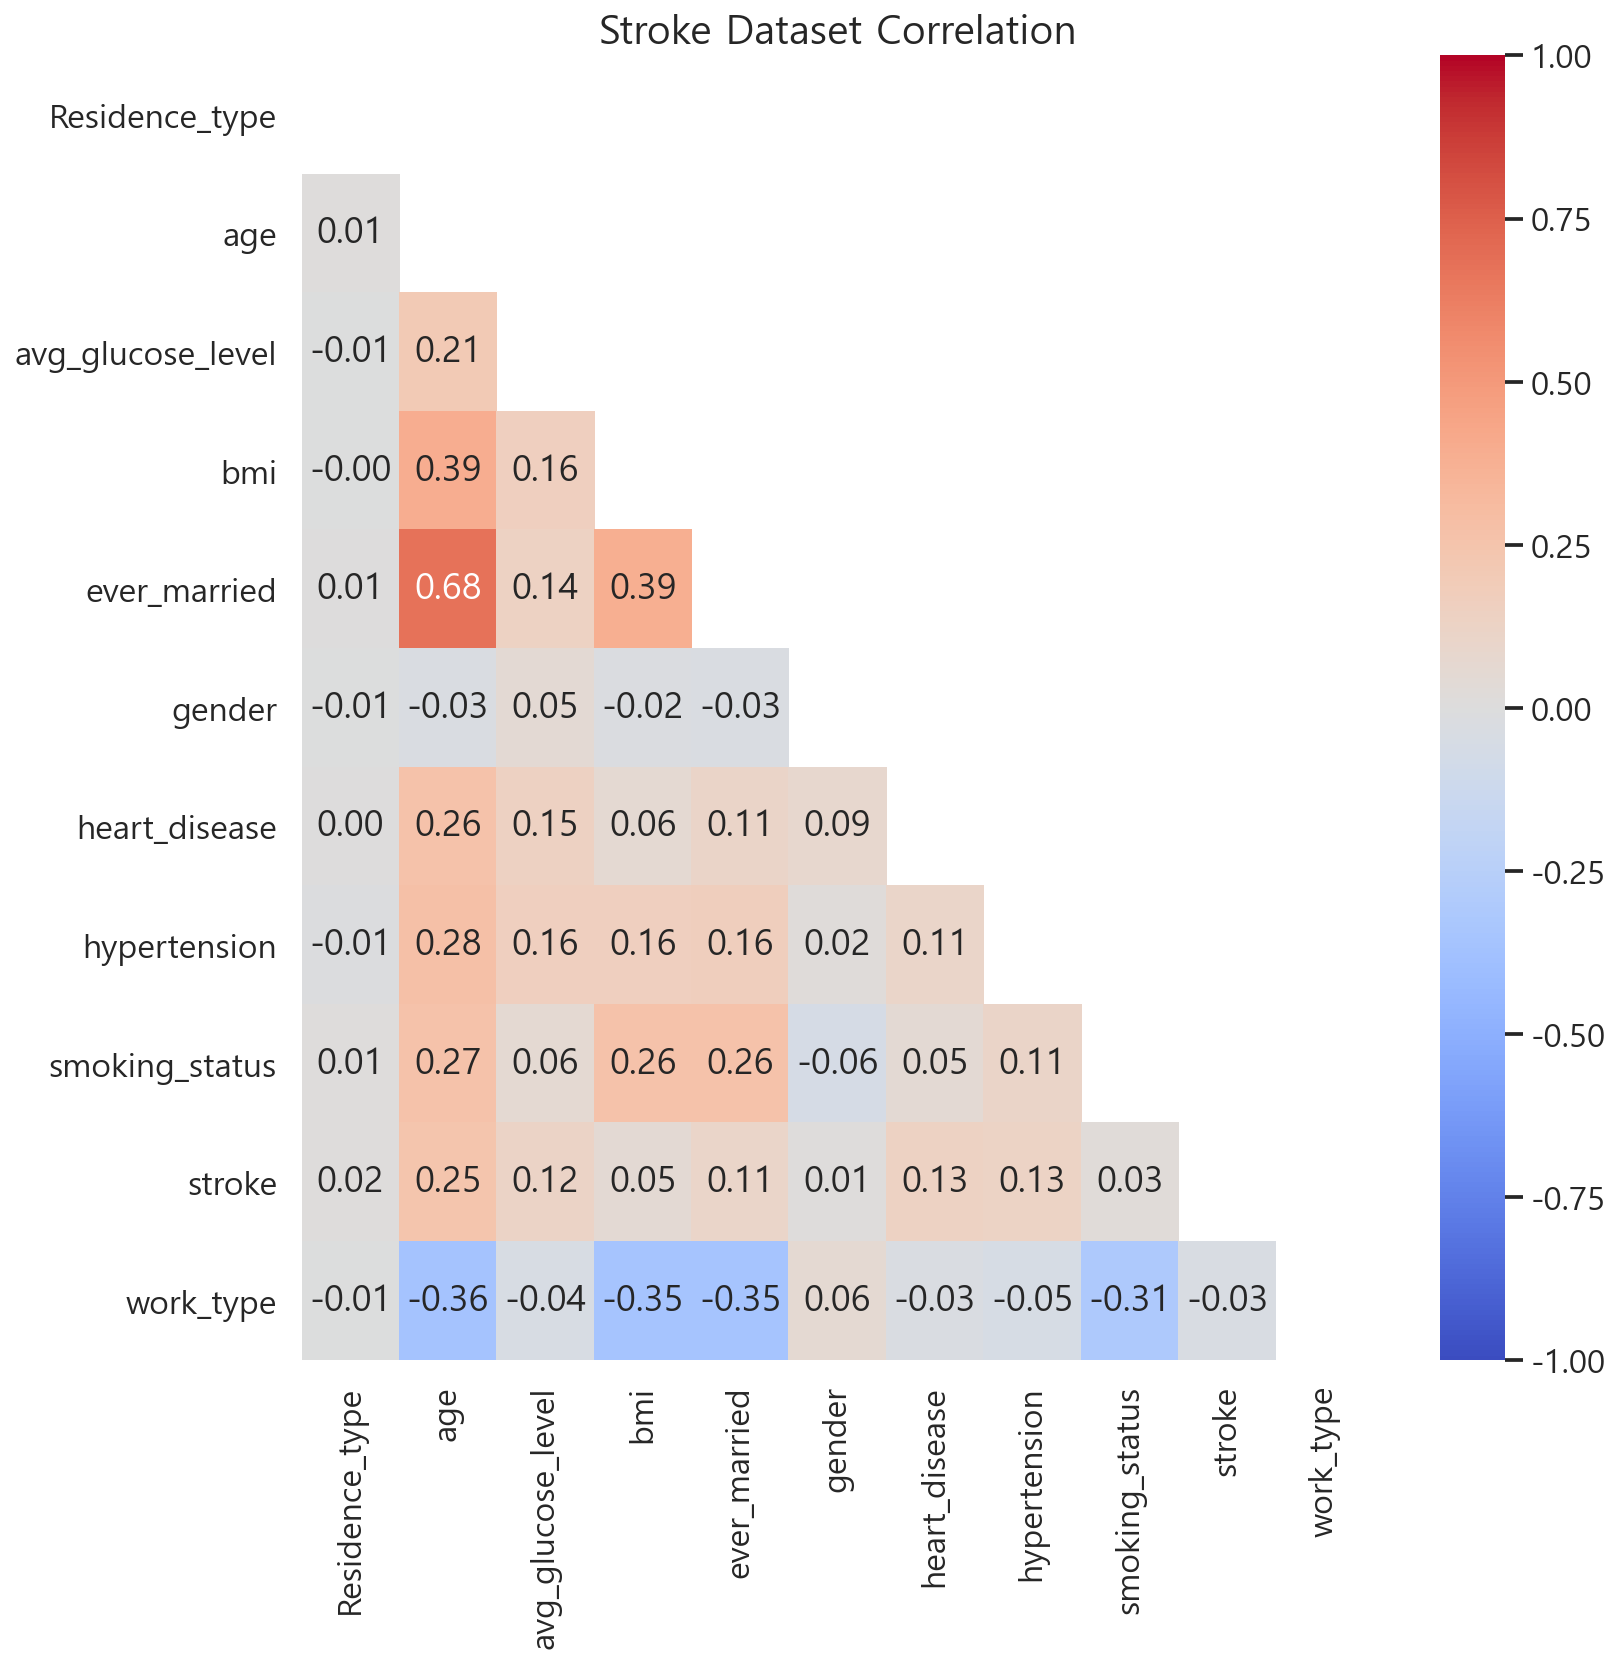

In [21]:
corr_plot(df, 'coolwarm',12, 12, 'Stroke Dataset Correlation')

In [22]:
# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('stroke',axis=1))
print('X_scaled.shape :',X_scaled.shape)

X_scaled.shape : (5109, 10)


## 4. ML Model Train

In [23]:
print('df.shape :',df.shape)
df.head()

df.shape : (5109, 11)


,Residence_type,age,avg_glucose_level,bmi,ever_married,gender,heart_disease,hypertension,smoking_status,stroke,work_type
0,1,67.0,5.436731,3.627004,1,1,1,0,1,1,2
1,0,61.0,5.314240,3.397677,1,0,0,0,2,1,3
2,0,80.0,4.672081,3.511545,1,1,1,0,2,1,2
3,1,49.0,5.148831,3.566712,1,0,0,0,3,1,2
4,0,79.0,5.165471,3.218876,1,0,0,1,2,1,3


### 데이터 분할

In [24]:
X_data = X_scaled
y_data = df['stroke']
print('X_data.shape :',X_data.shape)
print('y_data.shape :',y_data.shape,'\n')

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify = y_data,
                                                   shuffle=True, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_test.shape)
print('y_Test.shape :',y_test.shape)

X_data.shape : (5109, 10)
y_data.shape : (5109,) 

X_train.shape : (4087, 10)
y_train.shape : (4087,)
X_test.shape : (1022, 10)
y_Test.shape : (1022,)


### 데이터 오버샘플링

In [25]:
sm = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print('X_smote.shape :',X_smote.shape)
print('y_smote.shape :',y_smote.shape)

X_smote.shape : (7776, 10)
y_smote.shape : (7776,)


In [26]:
y_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: stroke, dtype: float64

### GridSearchCV

In [29]:
# 하이퍼파라미터 튜닝
model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth = 3)
evals = [(X_test,y_test)]
param_grid = {
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300,400],
}

grid_cv = GridSearchCV(model, cv=3, refit=True, param_grid=param_grid, scoring='f1')
grid_cv.fit(X_smote, y_smote, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)

[0]	validation_0-logloss:0.68884
[1]	validation_0-logloss:0.68463
[2]	validation_0-logloss:0.68050
[3]	validation_0-logloss:0.67648
[4]	validation_0-logloss:0.67253
[5]	validation_0-logloss:0.66866
[6]	validation_0-logloss:0.66486
[7]	validation_0-logloss:0.66123
[8]	validation_0-logloss:0.65760
[9]	validation_0-logloss:0.65409
[10]	validation_0-logloss:0.65062
[11]	validation_0-logloss:0.64723
[12]	validation_0-logloss:0.64391
[13]	validation_0-logloss:0.64072
[14]	validation_0-logloss:0.63754
[15]	validation_0-logloss:0.63442
[16]	validation_0-logloss:0.63140
[17]	validation_0-logloss:0.62840
[18]	validation_0-logloss:0.62548
[19]	validation_0-logloss:0.62264
[20]	validation_0-logloss:0.61982
[21]	validation_0-logloss:0.61714
[22]	validation_0-logloss:0.61446
[23]	validation_0-logloss:0.61183
[24]	validation_0-logloss:0.60927
[25]	validation_0-logloss:0.60663
[26]	validation_0-logloss:0.60414
[27]	validation_0-logloss:0.60170
[28]	validation_0-logloss:0.59932
[29]	validation_0-loglos

[42]	validation_0-logloss:0.57146
[43]	validation_0-logloss:0.56966
[44]	validation_0-logloss:0.56788
[45]	validation_0-logloss:0.56614
[46]	validation_0-logloss:0.56444
[47]	validation_0-logloss:0.56275
[48]	validation_0-logloss:0.56113
[49]	validation_0-logloss:0.55951
[50]	validation_0-logloss:0.55797
[51]	validation_0-logloss:0.55634
[52]	validation_0-logloss:0.55481
[53]	validation_0-logloss:0.55324
[54]	validation_0-logloss:0.55174
[55]	validation_0-logloss:0.55021
[56]	validation_0-logloss:0.54878
[57]	validation_0-logloss:0.54739
[58]	validation_0-logloss:0.54593
[59]	validation_0-logloss:0.54457
[60]	validation_0-logloss:0.54316
[61]	validation_0-logloss:0.54188
[62]	validation_0-logloss:0.54056
[63]	validation_0-logloss:0.53922
[64]	validation_0-logloss:0.53797
[65]	validation_0-logloss:0.53667
[66]	validation_0-logloss:0.53546
[67]	validation_0-logloss:0.53425
[68]	validation_0-logloss:0.53300
[69]	validation_0-logloss:0.53192
[70]	validation_0-logloss:0.53081
[71]	validatio

[181]	validation_0-logloss:0.43883
[182]	validation_0-logloss:0.43839
[183]	validation_0-logloss:0.43771
[184]	validation_0-logloss:0.43702
[185]	validation_0-logloss:0.43665
[186]	validation_0-logloss:0.43633
[187]	validation_0-logloss:0.43590
[188]	validation_0-logloss:0.43524
[189]	validation_0-logloss:0.43499
[190]	validation_0-logloss:0.43467
[191]	validation_0-logloss:0.43426
[192]	validation_0-logloss:0.43391
[193]	validation_0-logloss:0.43363
[194]	validation_0-logloss:0.43323
[195]	validation_0-logloss:0.43266
[196]	validation_0-logloss:0.43227
[197]	validation_0-logloss:0.43199
[198]	validation_0-logloss:0.43132
[199]	validation_0-logloss:0.43107
[0]	validation_0-logloss:0.68886
[1]	validation_0-logloss:0.68468
[2]	validation_0-logloss:0.68059
[3]	validation_0-logloss:0.67662
[4]	validation_0-logloss:0.67271
[5]	validation_0-logloss:0.66890
[6]	validation_0-logloss:0.66517
[7]	validation_0-logloss:0.66151
[8]	validation_0-logloss:0.65799
[9]	validation_0-logloss:0.65450
[10]	

[20]	validation_0-logloss:0.62077
[21]	validation_0-logloss:0.61806
[22]	validation_0-logloss:0.61539
[23]	validation_0-logloss:0.61278
[24]	validation_0-logloss:0.61013
[25]	validation_0-logloss:0.60767
[26]	validation_0-logloss:0.60520
[27]	validation_0-logloss:0.60277
[28]	validation_0-logloss:0.60041
[29]	validation_0-logloss:0.59808
[30]	validation_0-logloss:0.59579
[31]	validation_0-logloss:0.59354
[32]	validation_0-logloss:0.59132
[33]	validation_0-logloss:0.58918
[34]	validation_0-logloss:0.58706
[35]	validation_0-logloss:0.58497
[36]	validation_0-logloss:0.58292
[37]	validation_0-logloss:0.58091
[38]	validation_0-logloss:0.57893
[39]	validation_0-logloss:0.57706
[40]	validation_0-logloss:0.57518
[41]	validation_0-logloss:0.57330
[42]	validation_0-logloss:0.57146
[43]	validation_0-logloss:0.56966
[44]	validation_0-logloss:0.56788
[45]	validation_0-logloss:0.56614
[46]	validation_0-logloss:0.56444
[47]	validation_0-logloss:0.56275
[48]	validation_0-logloss:0.56113
[49]	validatio

[59]	validation_0-logloss:0.54312
[60]	validation_0-logloss:0.54180
[61]	validation_0-logloss:0.54053
[62]	validation_0-logloss:0.53922
[63]	validation_0-logloss:0.53797
[64]	validation_0-logloss:0.53675
[65]	validation_0-logloss:0.53554
[66]	validation_0-logloss:0.53437
[67]	validation_0-logloss:0.53320
[68]	validation_0-logloss:0.53155
[69]	validation_0-logloss:0.53036
[70]	validation_0-logloss:0.52926
[71]	validation_0-logloss:0.52818
[72]	validation_0-logloss:0.52712
[73]	validation_0-logloss:0.52555
[74]	validation_0-logloss:0.52447
[75]	validation_0-logloss:0.52291
[76]	validation_0-logloss:0.52191
[77]	validation_0-logloss:0.52044
[78]	validation_0-logloss:0.51894
[79]	validation_0-logloss:0.51796
[80]	validation_0-logloss:0.51686
[81]	validation_0-logloss:0.51571
[82]	validation_0-logloss:0.51469
[83]	validation_0-logloss:0.51353
[84]	validation_0-logloss:0.51211
[85]	validation_0-logloss:0.51075
[86]	validation_0-logloss:0.50964
[87]	validation_0-logloss:0.50869
[88]	validatio

[295]	validation_0-logloss:0.39153
[296]	validation_0-logloss:0.39107
[297]	validation_0-logloss:0.39093
[298]	validation_0-logloss:0.39063
[299]	validation_0-logloss:0.39018
[0]	validation_0-logloss:0.68886
[1]	validation_0-logloss:0.68468
[2]	validation_0-logloss:0.68059
[3]	validation_0-logloss:0.67662
[4]	validation_0-logloss:0.67271
[5]	validation_0-logloss:0.66890
[6]	validation_0-logloss:0.66517
[7]	validation_0-logloss:0.66151
[8]	validation_0-logloss:0.65799
[9]	validation_0-logloss:0.65450
[10]	validation_0-logloss:0.65113
[11]	validation_0-logloss:0.64779
[12]	validation_0-logloss:0.64426
[13]	validation_0-logloss:0.64109
[14]	validation_0-logloss:0.63790
[15]	validation_0-logloss:0.63457
[16]	validation_0-logloss:0.63155
[17]	validation_0-logloss:0.62855
[18]	validation_0-logloss:0.62540
[19]	validation_0-logloss:0.62262
[20]	validation_0-logloss:0.61988
[21]	validation_0-logloss:0.61718
[22]	validation_0-logloss:0.61446
[23]	validation_0-logloss:0.61178
[24]	validation_0-l

[233]	validation_0-logloss:0.42956
[234]	validation_0-logloss:0.42927
[235]	validation_0-logloss:0.42868
[236]	validation_0-logloss:0.42841
[237]	validation_0-logloss:0.42791
[238]	validation_0-logloss:0.42770
[239]	validation_0-logloss:0.42712
[240]	validation_0-logloss:0.42686
[241]	validation_0-logloss:0.42635
[242]	validation_0-logloss:0.42609
[243]	validation_0-logloss:0.42594
[244]	validation_0-logloss:0.42545
[245]	validation_0-logloss:0.42496
[246]	validation_0-logloss:0.42467
[247]	validation_0-logloss:0.42419
[248]	validation_0-logloss:0.42390
[249]	validation_0-logloss:0.42330
[250]	validation_0-logloss:0.42304
[251]	validation_0-logloss:0.42273
[252]	validation_0-logloss:0.42214
[253]	validation_0-logloss:0.42188
[254]	validation_0-logloss:0.42157
[255]	validation_0-logloss:0.42110
[256]	validation_0-logloss:0.42082
[257]	validation_0-logloss:0.42049
[258]	validation_0-logloss:0.41991
[259]	validation_0-logloss:0.41964
[260]	validation_0-logloss:0.41939
[261]	validation_0-l

[171]	validation_0-logloss:0.45510
[172]	validation_0-logloss:0.45476
[173]	validation_0-logloss:0.45402
[174]	validation_0-logloss:0.45361
[175]	validation_0-logloss:0.45328
[176]	validation_0-logloss:0.45288
[177]	validation_0-logloss:0.45245
[178]	validation_0-logloss:0.45202
[179]	validation_0-logloss:0.45134
[180]	validation_0-logloss:0.45105
[181]	validation_0-logloss:0.45063
[182]	validation_0-logloss:0.45033
[183]	validation_0-logloss:0.44966
[184]	validation_0-logloss:0.44942
[185]	validation_0-logloss:0.44900
[186]	validation_0-logloss:0.44860
[187]	validation_0-logloss:0.44823
[188]	validation_0-logloss:0.44802
[189]	validation_0-logloss:0.44738
[190]	validation_0-logloss:0.44709
[191]	validation_0-logloss:0.44669
[192]	validation_0-logloss:0.44647
[193]	validation_0-logloss:0.44619
[194]	validation_0-logloss:0.44554
[195]	validation_0-logloss:0.44517
[196]	validation_0-logloss:0.44479
[197]	validation_0-logloss:0.44441
[198]	validation_0-logloss:0.44413
[199]	validation_0-l

[109]	validation_0-logloss:0.48698
[110]	validation_0-logloss:0.48617
[111]	validation_0-logloss:0.48535
[112]	validation_0-logloss:0.48429
[113]	validation_0-logloss:0.48324
[114]	validation_0-logloss:0.48213
[115]	validation_0-logloss:0.48157
[116]	validation_0-logloss:0.48103
[117]	validation_0-logloss:0.48050
[118]	validation_0-logloss:0.47998
[119]	validation_0-logloss:0.47932
[120]	validation_0-logloss:0.47858
[121]	validation_0-logloss:0.47805
[122]	validation_0-logloss:0.47707
[123]	validation_0-logloss:0.47635
[124]	validation_0-logloss:0.47573
[125]	validation_0-logloss:0.47469
[126]	validation_0-logloss:0.47373
[127]	validation_0-logloss:0.47328
[128]	validation_0-logloss:0.47259
[129]	validation_0-logloss:0.47166
[130]	validation_0-logloss:0.47107
[131]	validation_0-logloss:0.47041
[132]	validation_0-logloss:0.46949
[133]	validation_0-logloss:0.46907
[134]	validation_0-logloss:0.46843
[135]	validation_0-logloss:0.46787
[136]	validation_0-logloss:0.46690
[137]	validation_0-l

[344]	validation_0-logloss:0.36802
[345]	validation_0-logloss:0.36764
[346]	validation_0-logloss:0.36740
[347]	validation_0-logloss:0.36714
[348]	validation_0-logloss:0.36663
[349]	validation_0-logloss:0.36625
[350]	validation_0-logloss:0.36585
[351]	validation_0-logloss:0.36548
[352]	validation_0-logloss:0.36497
[353]	validation_0-logloss:0.36455
[354]	validation_0-logloss:0.36419
[355]	validation_0-logloss:0.36381
[356]	validation_0-logloss:0.36371
[357]	validation_0-logloss:0.36330
[358]	validation_0-logloss:0.36290
[359]	validation_0-logloss:0.36254
[360]	validation_0-logloss:0.36216
[361]	validation_0-logloss:0.36202
[362]	validation_0-logloss:0.36167
[363]	validation_0-logloss:0.36117
[364]	validation_0-logloss:0.36093
[365]	validation_0-logloss:0.36054
[366]	validation_0-logloss:0.36015
[367]	validation_0-logloss:0.35979
[368]	validation_0-logloss:0.35944
[369]	validation_0-logloss:0.35895
[370]	validation_0-logloss:0.35857
[371]	validation_0-logloss:0.35819
[372]	validation_0-l

[182]	validation_0-logloss:0.44888
[183]	validation_0-logloss:0.44860
[184]	validation_0-logloss:0.44820
[185]	validation_0-logloss:0.44756
[186]	validation_0-logloss:0.44736
[187]	validation_0-logloss:0.44672
[188]	validation_0-logloss:0.44635
[189]	validation_0-logloss:0.44614
[190]	validation_0-logloss:0.44577
[191]	validation_0-logloss:0.44543
[192]	validation_0-logloss:0.44479
[193]	validation_0-logloss:0.44416
[194]	validation_0-logloss:0.44392
[195]	validation_0-logloss:0.44356
[196]	validation_0-logloss:0.44323
[197]	validation_0-logloss:0.44263
[198]	validation_0-logloss:0.44236
[199]	validation_0-logloss:0.44217
[200]	validation_0-logloss:0.44181
[201]	validation_0-logloss:0.44147
[202]	validation_0-logloss:0.44131
[203]	validation_0-logloss:0.44072
[204]	validation_0-logloss:0.44050
[205]	validation_0-logloss:0.44016
[206]	validation_0-logloss:0.44000
[207]	validation_0-logloss:0.43941
[208]	validation_0-logloss:0.43908
[209]	validation_0-logloss:0.43879
[210]	validation_0-l

[17]	validation_0-logloss:0.62919
[18]	validation_0-logloss:0.62633
[19]	validation_0-logloss:0.62350
[20]	validation_0-logloss:0.62077
[21]	validation_0-logloss:0.61806
[22]	validation_0-logloss:0.61539
[23]	validation_0-logloss:0.61278
[24]	validation_0-logloss:0.61013
[25]	validation_0-logloss:0.60767
[26]	validation_0-logloss:0.60520
[27]	validation_0-logloss:0.60277
[28]	validation_0-logloss:0.60041
[29]	validation_0-logloss:0.59808
[30]	validation_0-logloss:0.59579
[31]	validation_0-logloss:0.59354
[32]	validation_0-logloss:0.59132
[33]	validation_0-logloss:0.58918
[34]	validation_0-logloss:0.58706
[35]	validation_0-logloss:0.58497
[36]	validation_0-logloss:0.58292
[37]	validation_0-logloss:0.58091
[38]	validation_0-logloss:0.57893
[39]	validation_0-logloss:0.57706
[40]	validation_0-logloss:0.57518
[41]	validation_0-logloss:0.57330
[42]	validation_0-logloss:0.57146
[43]	validation_0-logloss:0.56966
[44]	validation_0-logloss:0.56788
[45]	validation_0-logloss:0.56614
[46]	validatio

[254]	validation_0-logloss:0.42178
[255]	validation_0-logloss:0.42157
[256]	validation_0-logloss:0.42101
[257]	validation_0-logloss:0.42089
[258]	validation_0-logloss:0.42048
[259]	validation_0-logloss:0.41991
[260]	validation_0-logloss:0.41972
[261]	validation_0-logloss:0.41931
[262]	validation_0-logloss:0.41882
[263]	validation_0-logloss:0.41859
[264]	validation_0-logloss:0.41819
[265]	validation_0-logloss:0.41796
[266]	validation_0-logloss:0.41784
[267]	validation_0-logloss:0.41765
[268]	validation_0-logloss:0.41726
[269]	validation_0-logloss:0.41712
[270]	validation_0-logloss:0.41649
[271]	validation_0-logloss:0.41603
[272]	validation_0-logloss:0.41565
[273]	validation_0-logloss:0.41547
[274]	validation_0-logloss:0.41510
[275]	validation_0-logloss:0.41447
[276]	validation_0-logloss:0.41424
[277]	validation_0-logloss:0.41406
[278]	validation_0-logloss:0.41370
[279]	validation_0-logloss:0.41347
[280]	validation_0-logloss:0.41284
[281]	validation_0-logloss:0.41240
[282]	validation_0-l

[91]	validation_0-logloss:0.33111
[92]	validation_0-logloss:0.32976
[93]	validation_0-logloss:0.32803
[94]	validation_0-logloss:0.32787
[95]	validation_0-logloss:0.32695
[96]	validation_0-logloss:0.32568
[97]	validation_0-logloss:0.32450
[98]	validation_0-logloss:0.32331
[99]	validation_0-logloss:0.32246
[0]	validation_0-logloss:0.67231
[1]	validation_0-logloss:0.65380
[2]	validation_0-logloss:0.63723
[3]	validation_0-logloss:0.62105
[4]	validation_0-logloss:0.60794
[5]	validation_0-logloss:0.59566
[6]	validation_0-logloss:0.58431
[7]	validation_0-logloss:0.57449
[8]	validation_0-logloss:0.56511
[9]	validation_0-logloss:0.55723
[10]	validation_0-logloss:0.54963
[11]	validation_0-logloss:0.54280
[12]	validation_0-logloss:0.53657
[13]	validation_0-logloss:0.53070
[14]	validation_0-logloss:0.52559
[15]	validation_0-logloss:0.52046
[16]	validation_0-logloss:0.51369
[17]	validation_0-logloss:0.50963
[18]	validation_0-logloss:0.50525
[19]	validation_0-logloss:0.49944
[20]	validation_0-loglos

[33]	validation_0-logloss:0.44343
[34]	validation_0-logloss:0.43984
[35]	validation_0-logloss:0.43757
[36]	validation_0-logloss:0.43585
[37]	validation_0-logloss:0.43405
[38]	validation_0-logloss:0.43087
[39]	validation_0-logloss:0.42875
[40]	validation_0-logloss:0.42542
[41]	validation_0-logloss:0.42421
[42]	validation_0-logloss:0.42257
[43]	validation_0-logloss:0.42098
[44]	validation_0-logloss:0.42020
[45]	validation_0-logloss:0.41828
[46]	validation_0-logloss:0.41689
[47]	validation_0-logloss:0.41619
[48]	validation_0-logloss:0.41420
[49]	validation_0-logloss:0.41329
[50]	validation_0-logloss:0.41231
[51]	validation_0-logloss:0.41072
[52]	validation_0-logloss:0.40788
[53]	validation_0-logloss:0.40558
[54]	validation_0-logloss:0.40301
[55]	validation_0-logloss:0.39954
[56]	validation_0-logloss:0.39857
[57]	validation_0-logloss:0.39625
[58]	validation_0-logloss:0.39306
[59]	validation_0-logloss:0.39182
[60]	validation_0-logloss:0.38997
[61]	validation_0-logloss:0.38767
[62]	validatio

[72]	validation_0-logloss:0.37994
[73]	validation_0-logloss:0.37900
[74]	validation_0-logloss:0.37794
[75]	validation_0-logloss:0.37409
[76]	validation_0-logloss:0.37368
[77]	validation_0-logloss:0.36987
[78]	validation_0-logloss:0.36880
[79]	validation_0-logloss:0.36712
[80]	validation_0-logloss:0.36503
[81]	validation_0-logloss:0.36431
[82]	validation_0-logloss:0.36390
[83]	validation_0-logloss:0.36287
[84]	validation_0-logloss:0.36263
[85]	validation_0-logloss:0.36111
[86]	validation_0-logloss:0.36044
[87]	validation_0-logloss:0.35714
[88]	validation_0-logloss:0.35621
[89]	validation_0-logloss:0.35559
[90]	validation_0-logloss:0.35369
[91]	validation_0-logloss:0.35298
[92]	validation_0-logloss:0.35233
[93]	validation_0-logloss:0.34949
[94]	validation_0-logloss:0.34854
[95]	validation_0-logloss:0.34588
[96]	validation_0-logloss:0.34456
[97]	validation_0-logloss:0.34408
[98]	validation_0-logloss:0.34369
[99]	validation_0-logloss:0.34257
[100]	validation_0-logloss:0.33991
[101]	validat

[111]	validation_0-logloss:0.32699
[112]	validation_0-logloss:0.32587
[113]	validation_0-logloss:0.32520
[114]	validation_0-logloss:0.32494
[115]	validation_0-logloss:0.32425
[116]	validation_0-logloss:0.32329
[117]	validation_0-logloss:0.32219
[118]	validation_0-logloss:0.32161
[119]	validation_0-logloss:0.32154
[120]	validation_0-logloss:0.32108
[121]	validation_0-logloss:0.32043
[122]	validation_0-logloss:0.31929
[123]	validation_0-logloss:0.31854
[124]	validation_0-logloss:0.31785
[125]	validation_0-logloss:0.31718
[126]	validation_0-logloss:0.31599
[127]	validation_0-logloss:0.31519
[128]	validation_0-logloss:0.31475
[129]	validation_0-logloss:0.31372
[130]	validation_0-logloss:0.31303
[131]	validation_0-logloss:0.31244
[132]	validation_0-logloss:0.31186
[133]	validation_0-logloss:0.31132
[134]	validation_0-logloss:0.31058
[135]	validation_0-logloss:0.31053
[136]	validation_0-logloss:0.30978
[137]	validation_0-logloss:0.30942
[138]	validation_0-logloss:0.30877
[139]	validation_0-l

[149]	validation_0-logloss:0.28153
[150]	validation_0-logloss:0.28094
[151]	validation_0-logloss:0.28056
[152]	validation_0-logloss:0.27923
[153]	validation_0-logloss:0.27900
[154]	validation_0-logloss:0.27817
[155]	validation_0-logloss:0.27782
[156]	validation_0-logloss:0.27705
[157]	validation_0-logloss:0.27687
[158]	validation_0-logloss:0.27643
[159]	validation_0-logloss:0.27568
[160]	validation_0-logloss:0.27569
[161]	validation_0-logloss:0.27461
[162]	validation_0-logloss:0.27441
[163]	validation_0-logloss:0.27412
[164]	validation_0-logloss:0.27334
[165]	validation_0-logloss:0.27334
[166]	validation_0-logloss:0.27285
[167]	validation_0-logloss:0.27273
[168]	validation_0-logloss:0.27225
[169]	validation_0-logloss:0.27113
[170]	validation_0-logloss:0.27095
[171]	validation_0-logloss:0.27031
[172]	validation_0-logloss:0.27024
[173]	validation_0-logloss:0.26977
[174]	validation_0-logloss:0.26968
[175]	validation_0-logloss:0.26967
[176]	validation_0-logloss:0.26899
[177]	validation_0-l

[86]	validation_0-logloss:0.36044
[87]	validation_0-logloss:0.35714
[88]	validation_0-logloss:0.35621
[89]	validation_0-logloss:0.35559
[90]	validation_0-logloss:0.35369
[91]	validation_0-logloss:0.35298
[92]	validation_0-logloss:0.35233
[93]	validation_0-logloss:0.34949
[94]	validation_0-logloss:0.34854
[95]	validation_0-logloss:0.34588
[96]	validation_0-logloss:0.34456
[97]	validation_0-logloss:0.34408
[98]	validation_0-logloss:0.34369
[99]	validation_0-logloss:0.34257
[100]	validation_0-logloss:0.33991
[101]	validation_0-logloss:0.33925
[102]	validation_0-logloss:0.33927
[103]	validation_0-logloss:0.33885
[104]	validation_0-logloss:0.33814
[105]	validation_0-logloss:0.33590
[106]	validation_0-logloss:0.33487
[107]	validation_0-logloss:0.33492
[108]	validation_0-logloss:0.33447
[109]	validation_0-logloss:0.33385
[110]	validation_0-logloss:0.33377
[111]	validation_0-logloss:0.33240
[112]	validation_0-logloss:0.33191
[113]	validation_0-logloss:0.33061
[114]	validation_0-logloss:0.32908

[22]	validation_0-logloss:0.48667
[23]	validation_0-logloss:0.48392
[24]	validation_0-logloss:0.48093
[25]	validation_0-logloss:0.47614
[26]	validation_0-logloss:0.47355
[27]	validation_0-logloss:0.47087
[28]	validation_0-logloss:0.46730
[29]	validation_0-logloss:0.46471
[30]	validation_0-logloss:0.46057
[31]	validation_0-logloss:0.45891
[32]	validation_0-logloss:0.45503
[33]	validation_0-logloss:0.45284
[34]	validation_0-logloss:0.45109
[35]	validation_0-logloss:0.44917
[36]	validation_0-logloss:0.44761
[37]	validation_0-logloss:0.44418
[38]	validation_0-logloss:0.44235
[39]	validation_0-logloss:0.44024
[40]	validation_0-logloss:0.43694
[41]	validation_0-logloss:0.43601
[42]	validation_0-logloss:0.43419
[43]	validation_0-logloss:0.43143
[44]	validation_0-logloss:0.43004
[45]	validation_0-logloss:0.42705
[46]	validation_0-logloss:0.42536
[47]	validation_0-logloss:0.42292
[48]	validation_0-logloss:0.42005
[49]	validation_0-logloss:0.41870
[50]	validation_0-logloss:0.41634
[51]	validatio

[259]	validation_0-logloss:0.26134
[260]	validation_0-logloss:0.26122
[261]	validation_0-logloss:0.26091
[262]	validation_0-logloss:0.26090
[263]	validation_0-logloss:0.26098
[264]	validation_0-logloss:0.26098
[265]	validation_0-logloss:0.26055
[266]	validation_0-logloss:0.26037
[267]	validation_0-logloss:0.26031
[268]	validation_0-logloss:0.26024
[269]	validation_0-logloss:0.25979
[270]	validation_0-logloss:0.25951
[271]	validation_0-logloss:0.25951
[272]	validation_0-logloss:0.25943
[273]	validation_0-logloss:0.25944
[274]	validation_0-logloss:0.25906
[275]	validation_0-logloss:0.25895
[276]	validation_0-logloss:0.25860
[277]	validation_0-logloss:0.25868
[278]	validation_0-logloss:0.25852
[279]	validation_0-logloss:0.25820
[280]	validation_0-logloss:0.25812
[281]	validation_0-logloss:0.25812
[282]	validation_0-logloss:0.25784
[283]	validation_0-logloss:0.25747
[284]	validation_0-logloss:0.25722
[285]	validation_0-logloss:0.25717
[286]	validation_0-logloss:0.25718
[287]	validation_0-l

[197]	validation_0-logloss:0.26223
[198]	validation_0-logloss:0.26192
[199]	validation_0-logloss:0.26187
[200]	validation_0-logloss:0.26095
[201]	validation_0-logloss:0.26094
[202]	validation_0-logloss:0.26082
[203]	validation_0-logloss:0.26079
[204]	validation_0-logloss:0.26013
[205]	validation_0-logloss:0.25979
[206]	validation_0-logloss:0.25980
[207]	validation_0-logloss:0.25978
[208]	validation_0-logloss:0.25933
[209]	validation_0-logloss:0.25853
[210]	validation_0-logloss:0.25810
[211]	validation_0-logloss:0.25795
[212]	validation_0-logloss:0.25748
[213]	validation_0-logloss:0.25738
[214]	validation_0-logloss:0.25715
[215]	validation_0-logloss:0.25637
[216]	validation_0-logloss:0.25648
[217]	validation_0-logloss:0.25640
[218]	validation_0-logloss:0.25590
[219]	validation_0-logloss:0.25581
[220]	validation_0-logloss:0.25505
[221]	validation_0-logloss:0.25507
[222]	validation_0-logloss:0.25515
[223]	validation_0-logloss:0.25485
[224]	validation_0-logloss:0.25486
[225]	validation_0-l

[33]	validation_0-logloss:0.45477
[34]	validation_0-logloss:0.45263
[35]	validation_0-logloss:0.45146
[36]	validation_0-logloss:0.44952
[37]	validation_0-logloss:0.44847
[38]	validation_0-logloss:0.44520
[39]	validation_0-logloss:0.44196
[40]	validation_0-logloss:0.44083
[41]	validation_0-logloss:0.43918
[42]	validation_0-logloss:0.43759
[43]	validation_0-logloss:0.43606
[44]	validation_0-logloss:0.43328
[45]	validation_0-logloss:0.43201
[46]	validation_0-logloss:0.43050
[47]	validation_0-logloss:0.42778
[48]	validation_0-logloss:0.42681
[49]	validation_0-logloss:0.42433
[50]	validation_0-logloss:0.42122
[51]	validation_0-logloss:0.42058
[52]	validation_0-logloss:0.41927
[53]	validation_0-logloss:0.41644
[54]	validation_0-logloss:0.41441
[55]	validation_0-logloss:0.41198
[56]	validation_0-logloss:0.40890
[57]	validation_0-logloss:0.40702
[58]	validation_0-logloss:0.40577
[59]	validation_0-logloss:0.40353
[60]	validation_0-logloss:0.40178
[61]	validation_0-logloss:0.40079
[62]	validatio

[269]	validation_0-logloss:0.26779
[270]	validation_0-logloss:0.26779
[271]	validation_0-logloss:0.26786
[272]	validation_0-logloss:0.26778
[273]	validation_0-logloss:0.26723
[274]	validation_0-logloss:0.26707
[275]	validation_0-logloss:0.26684
[276]	validation_0-logloss:0.26656
[277]	validation_0-logloss:0.26653
[278]	validation_0-logloss:0.26638
[279]	validation_0-logloss:0.26620
[280]	validation_0-logloss:0.26583
[281]	validation_0-logloss:0.26545
[282]	validation_0-logloss:0.26508
[283]	validation_0-logloss:0.26474
[284]	validation_0-logloss:0.26475
[285]	validation_0-logloss:0.26467
[286]	validation_0-logloss:0.26434
[287]	validation_0-logloss:0.26420
[288]	validation_0-logloss:0.26426
[289]	validation_0-logloss:0.26405
[290]	validation_0-logloss:0.26404
[291]	validation_0-logloss:0.26368
[292]	validation_0-logloss:0.26370
[293]	validation_0-logloss:0.26363
[294]	validation_0-logloss:0.26361
[295]	validation_0-logloss:0.26366
[296]	validation_0-logloss:0.26343
[297]	validation_0-l

[107]	validation_0-logloss:0.33008
[108]	validation_0-logloss:0.32924
[109]	validation_0-logloss:0.32885
[110]	validation_0-logloss:0.32769
[111]	validation_0-logloss:0.32699
[112]	validation_0-logloss:0.32587
[113]	validation_0-logloss:0.32520
[114]	validation_0-logloss:0.32494
[115]	validation_0-logloss:0.32425
[116]	validation_0-logloss:0.32329
[117]	validation_0-logloss:0.32219
[118]	validation_0-logloss:0.32161
[119]	validation_0-logloss:0.32154
[120]	validation_0-logloss:0.32108
[121]	validation_0-logloss:0.32043
[122]	validation_0-logloss:0.31929
[123]	validation_0-logloss:0.31854
[124]	validation_0-logloss:0.31785
[125]	validation_0-logloss:0.31718
[126]	validation_0-logloss:0.31599
[127]	validation_0-logloss:0.31519
[128]	validation_0-logloss:0.31475
[129]	validation_0-logloss:0.31372
[130]	validation_0-logloss:0.31303
[131]	validation_0-logloss:0.31244
[132]	validation_0-logloss:0.31186
[133]	validation_0-logloss:0.31132
[134]	validation_0-logloss:0.31058
[135]	validation_0-l

[342]	validation_0-logloss:0.24920
[343]	validation_0-logloss:0.24869
[344]	validation_0-logloss:0.24866
[345]	validation_0-logloss:0.24871
[346]	validation_0-logloss:0.24854
[347]	validation_0-logloss:0.24846
[348]	validation_0-logloss:0.24827
[349]	validation_0-logloss:0.24806
[350]	validation_0-logloss:0.24790
[351]	validation_0-logloss:0.24771
[352]	validation_0-logloss:0.24734
[353]	validation_0-logloss:0.24718
[354]	validation_0-logloss:0.24714
[355]	validation_0-logloss:0.24660
[356]	validation_0-logloss:0.24624
[357]	validation_0-logloss:0.24608
[358]	validation_0-logloss:0.24616
[359]	validation_0-logloss:0.24599
[360]	validation_0-logloss:0.24571
[361]	validation_0-logloss:0.24531
[362]	validation_0-logloss:0.24505
[363]	validation_0-logloss:0.24514
[364]	validation_0-logloss:0.24500
[365]	validation_0-logloss:0.24495
[366]	validation_0-logloss:0.24505
[367]	validation_0-logloss:0.24474
[368]	validation_0-logloss:0.24459
[369]	validation_0-logloss:0.24442
[370]	validation_0-l

[82]	validation_0-logloss:0.29336
[83]	validation_0-logloss:0.29350
[84]	validation_0-logloss:0.29260
[85]	validation_0-logloss:0.29234
[86]	validation_0-logloss:0.29120
[87]	validation_0-logloss:0.29012
[88]	validation_0-logloss:0.28934
[89]	validation_0-logloss:0.28893
[90]	validation_0-logloss:0.28918
[91]	validation_0-logloss:0.28840
[92]	validation_0-logloss:0.28741
[93]	validation_0-logloss:0.28709
[94]	validation_0-logloss:0.28619
[95]	validation_0-logloss:0.28508
[96]	validation_0-logloss:0.28438
[97]	validation_0-logloss:0.28338
[98]	validation_0-logloss:0.28331
[99]	validation_0-logloss:0.28316
[0]	validation_0-logloss:0.65295
[1]	validation_0-logloss:0.62151
[2]	validation_0-logloss:0.59594
[3]	validation_0-logloss:0.57480
[4]	validation_0-logloss:0.55762
[5]	validation_0-logloss:0.54293
[6]	validation_0-logloss:0.53005
[7]	validation_0-logloss:0.52001
[8]	validation_0-logloss:0.50745
[9]	validation_0-logloss:0.49907
[10]	validation_0-logloss:0.48914
[11]	validation_0-loglos

[123]	validation_0-logloss:0.24582
[124]	validation_0-logloss:0.24512
[125]	validation_0-logloss:0.24500
[126]	validation_0-logloss:0.24437
[127]	validation_0-logloss:0.24442
[128]	validation_0-logloss:0.24427
[129]	validation_0-logloss:0.24386
[130]	validation_0-logloss:0.24395
[131]	validation_0-logloss:0.24366
[132]	validation_0-logloss:0.24325
[133]	validation_0-logloss:0.24320
[134]	validation_0-logloss:0.24276
[135]	validation_0-logloss:0.24297
[136]	validation_0-logloss:0.24208
[137]	validation_0-logloss:0.24094
[138]	validation_0-logloss:0.24086
[139]	validation_0-logloss:0.24052
[140]	validation_0-logloss:0.24061
[141]	validation_0-logloss:0.24071
[142]	validation_0-logloss:0.23983
[143]	validation_0-logloss:0.23919
[144]	validation_0-logloss:0.23912
[145]	validation_0-logloss:0.23894
[146]	validation_0-logloss:0.23838
[147]	validation_0-logloss:0.23763
[148]	validation_0-logloss:0.23698
[149]	validation_0-logloss:0.23713
[150]	validation_0-logloss:0.23665
[151]	validation_0-l

[161]	validation_0-logloss:0.25988
[162]	validation_0-logloss:0.25953
[163]	validation_0-logloss:0.25893
[164]	validation_0-logloss:0.25914
[165]	validation_0-logloss:0.25913
[166]	validation_0-logloss:0.25887
[167]	validation_0-logloss:0.25897
[168]	validation_0-logloss:0.25900
[169]	validation_0-logloss:0.25886
[170]	validation_0-logloss:0.25838
[171]	validation_0-logloss:0.25825
[172]	validation_0-logloss:0.25820
[173]	validation_0-logloss:0.25808
[174]	validation_0-logloss:0.25738
[175]	validation_0-logloss:0.25743
[176]	validation_0-logloss:0.25753
[177]	validation_0-logloss:0.25669
[178]	validation_0-logloss:0.25623
[179]	validation_0-logloss:0.25639
[180]	validation_0-logloss:0.25657
[181]	validation_0-logloss:0.25647
[182]	validation_0-logloss:0.25600
[183]	validation_0-logloss:0.25579
[184]	validation_0-logloss:0.25557
[185]	validation_0-logloss:0.25465
[186]	validation_0-logloss:0.25406
[187]	validation_0-logloss:0.25377
[188]	validation_0-logloss:0.25386
[189]	validation_0-l

[199]	validation_0-logloss:0.23813
[0]	validation_0-logloss:0.65272
[1]	validation_0-logloss:0.62038
[2]	validation_0-logloss:0.59479
[3]	validation_0-logloss:0.57371
[4]	validation_0-logloss:0.55605
[5]	validation_0-logloss:0.54216
[6]	validation_0-logloss:0.52939
[7]	validation_0-logloss:0.51781
[8]	validation_0-logloss:0.50498
[9]	validation_0-logloss:0.49650
[10]	validation_0-logloss:0.48438
[11]	validation_0-logloss:0.47364
[12]	validation_0-logloss:0.46396
[13]	validation_0-logloss:0.45968
[14]	validation_0-logloss:0.45379
[15]	validation_0-logloss:0.44634
[16]	validation_0-logloss:0.44218
[17]	validation_0-logloss:0.43528
[18]	validation_0-logloss:0.42836
[19]	validation_0-logloss:0.42420
[20]	validation_0-logloss:0.41898
[21]	validation_0-logloss:0.41702
[22]	validation_0-logloss:0.41087
[23]	validation_0-logloss:0.40865
[24]	validation_0-logloss:0.40546
[25]	validation_0-logloss:0.40040
[26]	validation_0-logloss:0.39494
[27]	validation_0-logloss:0.39037
[28]	validation_0-loglo

[237]	validation_0-logloss:0.21844
[238]	validation_0-logloss:0.21823
[239]	validation_0-logloss:0.21799
[240]	validation_0-logloss:0.21776
[241]	validation_0-logloss:0.21757
[242]	validation_0-logloss:0.21771
[243]	validation_0-logloss:0.21796
[244]	validation_0-logloss:0.21763
[245]	validation_0-logloss:0.21774
[246]	validation_0-logloss:0.21757
[247]	validation_0-logloss:0.21749
[248]	validation_0-logloss:0.21765
[249]	validation_0-logloss:0.21715
[250]	validation_0-logloss:0.21712
[251]	validation_0-logloss:0.21731
[252]	validation_0-logloss:0.21735
[253]	validation_0-logloss:0.21723
[254]	validation_0-logloss:0.21710
[255]	validation_0-logloss:0.21652
[256]	validation_0-logloss:0.21639
[257]	validation_0-logloss:0.21664
[258]	validation_0-logloss:0.21688
[259]	validation_0-logloss:0.21709
[260]	validation_0-logloss:0.21699
[261]	validation_0-logloss:0.21699
[262]	validation_0-logloss:0.21629
[263]	validation_0-logloss:0.21588
[264]	validation_0-logloss:0.21578
[265]	validation_0-l

[175]	validation_0-logloss:0.25743
[176]	validation_0-logloss:0.25753
[177]	validation_0-logloss:0.25669
[178]	validation_0-logloss:0.25623
[179]	validation_0-logloss:0.25639
[180]	validation_0-logloss:0.25657
[181]	validation_0-logloss:0.25647
[182]	validation_0-logloss:0.25600
[183]	validation_0-logloss:0.25579
[184]	validation_0-logloss:0.25557
[185]	validation_0-logloss:0.25465
[186]	validation_0-logloss:0.25406
[187]	validation_0-logloss:0.25377
[188]	validation_0-logloss:0.25386
[189]	validation_0-logloss:0.25382
[190]	validation_0-logloss:0.25335
[191]	validation_0-logloss:0.25315
[192]	validation_0-logloss:0.25316
[193]	validation_0-logloss:0.25284
[194]	validation_0-logloss:0.25290
[195]	validation_0-logloss:0.25238
[196]	validation_0-logloss:0.25201
[197]	validation_0-logloss:0.25182
[198]	validation_0-logloss:0.25141
[199]	validation_0-logloss:0.25139
[200]	validation_0-logloss:0.25143
[201]	validation_0-logloss:0.25141
[202]	validation_0-logloss:0.25054
[203]	validation_0-l

[113]	validation_0-logloss:0.26960
[114]	validation_0-logloss:0.26951
[115]	validation_0-logloss:0.26826
[116]	validation_0-logloss:0.26756
[117]	validation_0-logloss:0.26710
[118]	validation_0-logloss:0.26682
[119]	validation_0-logloss:0.26630
[120]	validation_0-logloss:0.26604
[121]	validation_0-logloss:0.26561
[122]	validation_0-logloss:0.26536
[123]	validation_0-logloss:0.26432
[124]	validation_0-logloss:0.26396
[125]	validation_0-logloss:0.26344
[126]	validation_0-logloss:0.26347
[127]	validation_0-logloss:0.26226
[128]	validation_0-logloss:0.26173
[129]	validation_0-logloss:0.26129
[130]	validation_0-logloss:0.26094
[131]	validation_0-logloss:0.25958
[132]	validation_0-logloss:0.25956
[133]	validation_0-logloss:0.25890
[134]	validation_0-logloss:0.25817
[135]	validation_0-logloss:0.25769
[136]	validation_0-logloss:0.25749
[137]	validation_0-logloss:0.25736
[138]	validation_0-logloss:0.25607
[139]	validation_0-logloss:0.25540
[140]	validation_0-logloss:0.25526
[141]	validation_0-l

[49]	validation_0-logloss:0.32163
[50]	validation_0-logloss:0.32153
[51]	validation_0-logloss:0.31924
[52]	validation_0-logloss:0.31394
[53]	validation_0-logloss:0.31121
[54]	validation_0-logloss:0.30866
[55]	validation_0-logloss:0.30682
[56]	validation_0-logloss:0.30658
[57]	validation_0-logloss:0.30659
[58]	validation_0-logloss:0.30422
[59]	validation_0-logloss:0.30223
[60]	validation_0-logloss:0.29801
[61]	validation_0-logloss:0.29688
[62]	validation_0-logloss:0.29511
[63]	validation_0-logloss:0.29370
[64]	validation_0-logloss:0.29176
[65]	validation_0-logloss:0.28951
[66]	validation_0-logloss:0.28766
[67]	validation_0-logloss:0.28652
[68]	validation_0-logloss:0.28575
[69]	validation_0-logloss:0.28593
[70]	validation_0-logloss:0.28606
[71]	validation_0-logloss:0.28429
[72]	validation_0-logloss:0.28276
[73]	validation_0-logloss:0.28223
[74]	validation_0-logloss:0.28093
[75]	validation_0-logloss:0.27963
[76]	validation_0-logloss:0.27864
[77]	validation_0-logloss:0.27685
[78]	validatio

[285]	validation_0-logloss:0.21375
[286]	validation_0-logloss:0.21339
[287]	validation_0-logloss:0.21280
[288]	validation_0-logloss:0.21304
[289]	validation_0-logloss:0.21302
[290]	validation_0-logloss:0.21268
[291]	validation_0-logloss:0.21243
[292]	validation_0-logloss:0.21265
[293]	validation_0-logloss:0.21230
[294]	validation_0-logloss:0.21250
[295]	validation_0-logloss:0.21246
[296]	validation_0-logloss:0.21224
[297]	validation_0-logloss:0.21244
[298]	validation_0-logloss:0.21227
[299]	validation_0-logloss:0.21196
[300]	validation_0-logloss:0.21165
[301]	validation_0-logloss:0.21178
[302]	validation_0-logloss:0.21128
[303]	validation_0-logloss:0.21144
[304]	validation_0-logloss:0.21127
[305]	validation_0-logloss:0.21120
[306]	validation_0-logloss:0.21124
[307]	validation_0-logloss:0.21129
[308]	validation_0-logloss:0.21048
[309]	validation_0-logloss:0.21034
[310]	validation_0-logloss:0.21020
[311]	validation_0-logloss:0.20985
[312]	validation_0-logloss:0.21003
[313]	validation_0-l

[123]	validation_0-logloss:0.27239
[124]	validation_0-logloss:0.27184
[125]	validation_0-logloss:0.27080
[126]	validation_0-logloss:0.27052
[127]	validation_0-logloss:0.26939
[128]	validation_0-logloss:0.26914
[129]	validation_0-logloss:0.26885
[130]	validation_0-logloss:0.26830
[131]	validation_0-logloss:0.26739
[132]	validation_0-logloss:0.26727
[133]	validation_0-logloss:0.26715
[134]	validation_0-logloss:0.26712
[135]	validation_0-logloss:0.26684
[136]	validation_0-logloss:0.26619
[137]	validation_0-logloss:0.26537
[138]	validation_0-logloss:0.26539
[139]	validation_0-logloss:0.26539
[140]	validation_0-logloss:0.26581
[141]	validation_0-logloss:0.26543
[142]	validation_0-logloss:0.26555
[143]	validation_0-logloss:0.26528
[144]	validation_0-logloss:0.26528
[145]	validation_0-logloss:0.26512
[146]	validation_0-logloss:0.26482
[147]	validation_0-logloss:0.26471
[148]	validation_0-logloss:0.26420
[149]	validation_0-logloss:0.26405
[150]	validation_0-logloss:0.26379
[151]	validation_0-l

[358]	validation_0-logloss:0.23172
[359]	validation_0-logloss:0.23164
[360]	validation_0-logloss:0.23174
[361]	validation_0-logloss:0.23169
[362]	validation_0-logloss:0.23129
[363]	validation_0-logloss:0.23129
[364]	validation_0-logloss:0.23135
[365]	validation_0-logloss:0.23126
[366]	validation_0-logloss:0.23126
[367]	validation_0-logloss:0.23095
[368]	validation_0-logloss:0.23117
[369]	validation_0-logloss:0.23112
[370]	validation_0-logloss:0.23121
[371]	validation_0-logloss:0.23129
[372]	validation_0-logloss:0.23115
[373]	validation_0-logloss:0.23134
[374]	validation_0-logloss:0.23142
[375]	validation_0-logloss:0.23140
[376]	validation_0-logloss:0.23125
[377]	validation_0-logloss:0.23108
[378]	validation_0-logloss:0.23069
[379]	validation_0-logloss:0.23084
[380]	validation_0-logloss:0.23090
[381]	validation_0-logloss:0.23082
[382]	validation_0-logloss:0.23085
[383]	validation_0-logloss:0.23103
[384]	validation_0-logloss:0.23101
[385]	validation_0-logloss:0.23068
[386]	validation_0-l

[196]	validation_0-logloss:0.23852
[197]	validation_0-logloss:0.23864
[198]	validation_0-logloss:0.23843
[199]	validation_0-logloss:0.23813
[200]	validation_0-logloss:0.23831
[201]	validation_0-logloss:0.23804
[202]	validation_0-logloss:0.23736
[203]	validation_0-logloss:0.23698
[204]	validation_0-logloss:0.23636
[205]	validation_0-logloss:0.23622
[206]	validation_0-logloss:0.23531
[207]	validation_0-logloss:0.23442
[208]	validation_0-logloss:0.23431
[209]	validation_0-logloss:0.23400
[210]	validation_0-logloss:0.23393
[211]	validation_0-logloss:0.23397
[212]	validation_0-logloss:0.23387
[213]	validation_0-logloss:0.23359
[214]	validation_0-logloss:0.23349
[215]	validation_0-logloss:0.23330
[216]	validation_0-logloss:0.23307
[217]	validation_0-logloss:0.23287
[218]	validation_0-logloss:0.23268
[219]	validation_0-logloss:0.23256
[220]	validation_0-logloss:0.23246
[221]	validation_0-logloss:0.23164
[222]	validation_0-logloss:0.23152
[223]	validation_0-logloss:0.23113
[224]	validation_0-l

[32]	validation_0-logloss:0.38163
[33]	validation_0-logloss:0.37815
[34]	validation_0-logloss:0.37628
[35]	validation_0-logloss:0.36869
[36]	validation_0-logloss:0.36805
[37]	validation_0-logloss:0.36304
[38]	validation_0-logloss:0.35917
[39]	validation_0-logloss:0.35642
[40]	validation_0-logloss:0.35394
[41]	validation_0-logloss:0.35289
[42]	validation_0-logloss:0.34690
[43]	validation_0-logloss:0.34302
[44]	validation_0-logloss:0.33760
[45]	validation_0-logloss:0.33438
[46]	validation_0-logloss:0.33157
[47]	validation_0-logloss:0.32796
[48]	validation_0-logloss:0.32717
[49]	validation_0-logloss:0.32459
[50]	validation_0-logloss:0.32416
[51]	validation_0-logloss:0.32388
[52]	validation_0-logloss:0.32288
[53]	validation_0-logloss:0.31946
[54]	validation_0-logloss:0.31563
[55]	validation_0-logloss:0.31343
[56]	validation_0-logloss:0.31315
[57]	validation_0-logloss:0.31185
[58]	validation_0-logloss:0.31015
[59]	validation_0-logloss:0.30792
[60]	validation_0-logloss:0.30468
[61]	validatio

[269]	validation_0-logloss:0.21384
[270]	validation_0-logloss:0.21388
[271]	validation_0-logloss:0.21357
[272]	validation_0-logloss:0.21331
[273]	validation_0-logloss:0.21349
[274]	validation_0-logloss:0.21348
[275]	validation_0-logloss:0.21338
[276]	validation_0-logloss:0.21280
[277]	validation_0-logloss:0.21275
[278]	validation_0-logloss:0.21263
[279]	validation_0-logloss:0.21233
[280]	validation_0-logloss:0.21227
[281]	validation_0-logloss:0.21256
[282]	validation_0-logloss:0.21241
[283]	validation_0-logloss:0.21221
[284]	validation_0-logloss:0.21196
[285]	validation_0-logloss:0.21186
[286]	validation_0-logloss:0.21204
[287]	validation_0-logloss:0.21196
[288]	validation_0-logloss:0.21164
[289]	validation_0-logloss:0.21159
[290]	validation_0-logloss:0.21157
[291]	validation_0-logloss:0.21143
[292]	validation_0-logloss:0.21138
[293]	validation_0-logloss:0.21119
[294]	validation_0-logloss:0.21111
[295]	validation_0-logloss:0.21115
[296]	validation_0-logloss:0.21080
[297]	validation_0-l

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=400, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [30]:
# GridSearchCV 결과
score_df = pd.DataFrame(grid_cv.cv_results_)
score_df[['params','mean_test_score','rank_test_score','split0_test_score']].sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score,split0_test_score
11,"{'learning_rate': 0.1, 'n_estimators': 400}",0.943625,1,0.902714
10,"{'learning_rate': 0.1, 'n_estimators': 300}",0.936224,2,0.894451
7,"{'learning_rate': 0.05, 'n_estimators': 400}",0.924071,3,0.885300
9,"{'learning_rate': 0.1, 'n_estimators': 200}",0.923282,4,0.885477
6,"{'learning_rate': 0.05, 'n_estimators': 300}",0.914473,5,0.877451


In [31]:
print('grid_cv.best_params_ :',grid_cv.best_params_)
print("grid_cv.best_score_ :",grid_cv.best_score_)

grid_cv.best_params_ : {'learning_rate': 0.1, 'n_estimators': 400}
grid_cv.best_score_ : 0.9436249421516782


In [32]:
# 최고 성능 파라미터와 추정기 불러오기
best_est = grid_cv.best_estimator_
best_param = grid_cv.best_params_
best_param

{'learning_rate': 0.1, 'n_estimators': 400}

In [33]:
# train data Evalutation
best_train_pred = best_est.predict(X_smote)
print('X_train ACC :',np.round(accuracy_score(best_train_pred,y_smote),4),'\n')
get_clf_eval(y_smote,best_train_pred)

X_train ACC : 0.9756 

[[3850   38]
 [ 152 3736]]
정확도 :0.9756, 정밀도 :0.9899, 재현율 :0.9609, F1 :0.9752


In [34]:
# test data Evalutation
best_test_pred = best_est.predict(X_test)
print('X_test ACC :',np.round(accuracy_score(best_test_pred,y_test),4),'\n')
get_clf_eval(y_test,best_test_pred)

X_test ACC : 0.9403 

[[954  18]
 [ 43   7]]
정확도 :0.9403, 정밀도 :0.2800, 재현율 :0.1400, F1 :0.1867


## 6. Precision & Recall TradeOff

In [35]:
best_train_proba = best_est.predict_proba(X_smote)
best_train_proba_1 = best_train_proba[:,1]

best_test_proba = best_est.predict_proba(X_test)
best_test_proba_1 = best_test_proba[:,1]

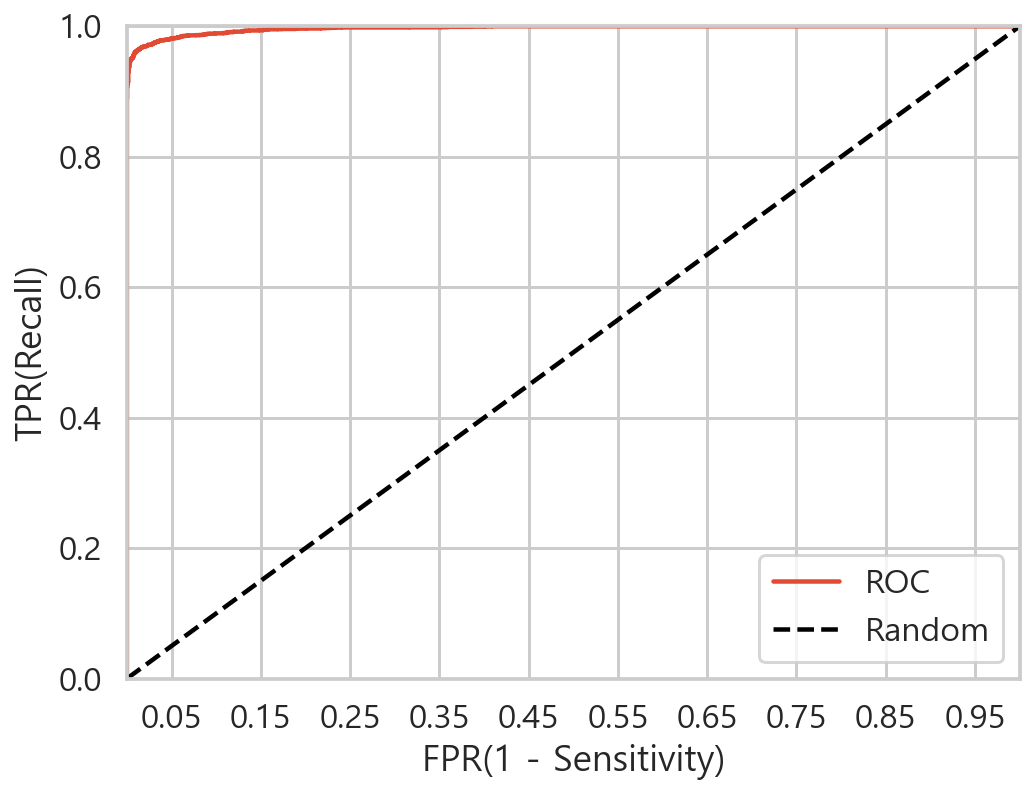

In [36]:
roc_curve_plot(y_smote, best_train_proba_1)

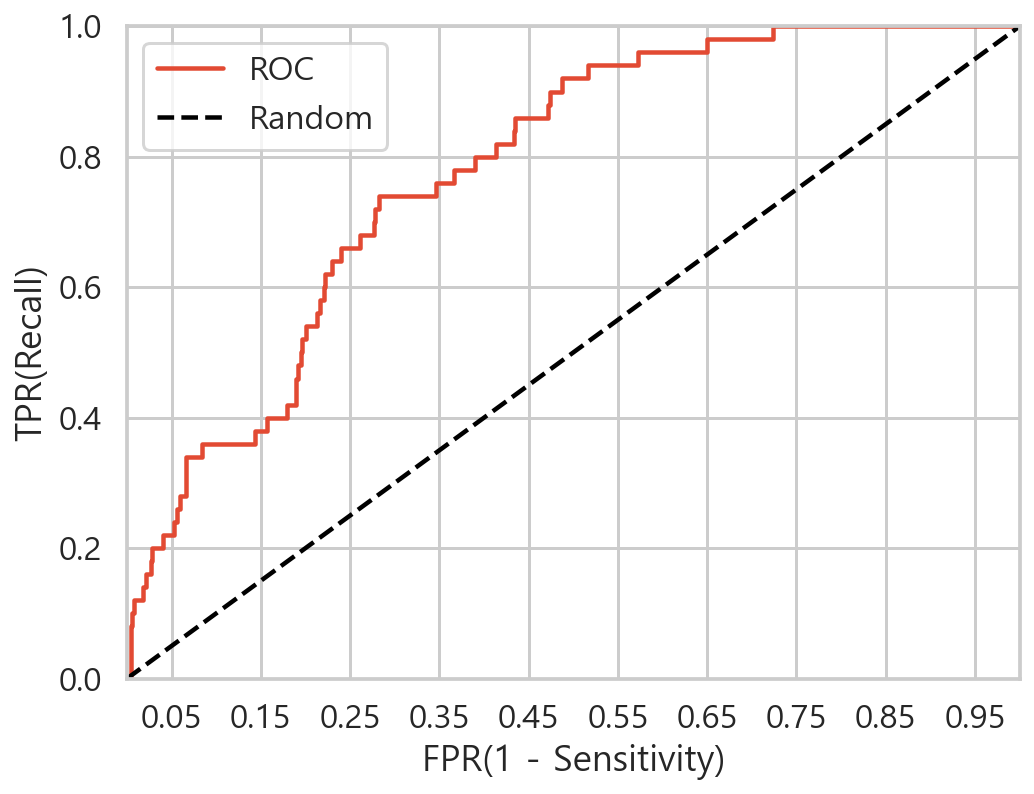

In [37]:
roc_curve_plot(y_test, best_test_proba_1)

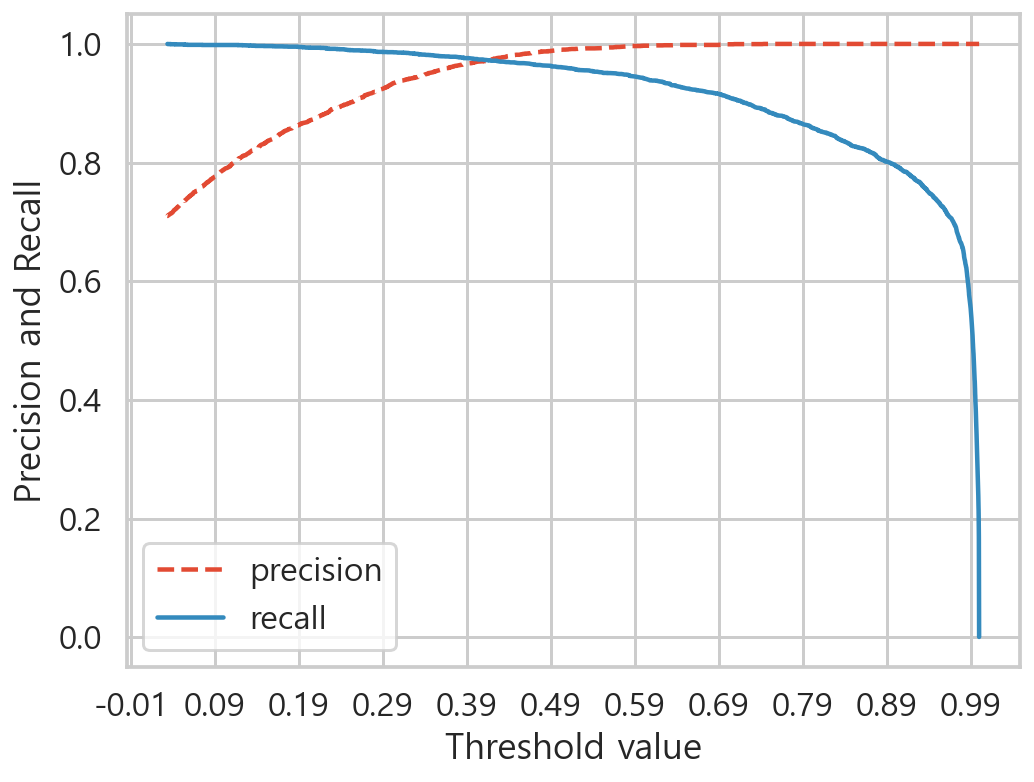

In [38]:
precision_recall_curve_plot(y_smote,best_train_proba_1)

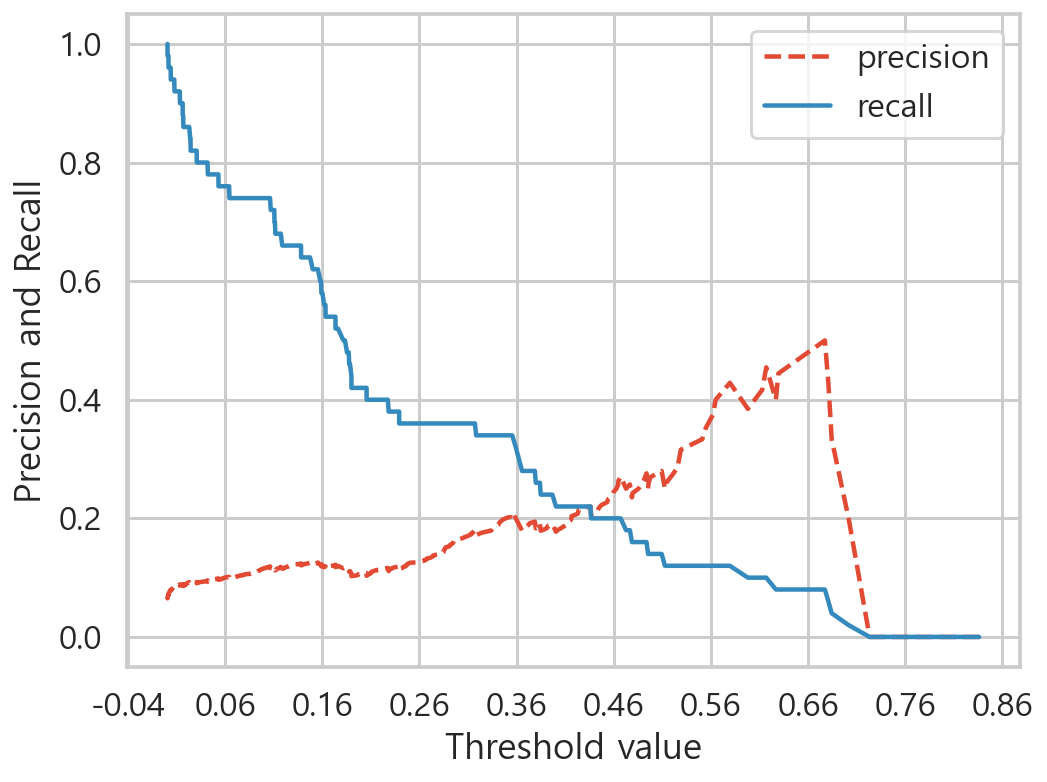

In [39]:
precision_recall_curve_plot(y_test,best_test_proba_1)

## 7. 사후 튜닝

In [40]:
after_pred = (best_test_proba[:,1] > 0.27)*1
after_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
get_clf_eval(y_test,after_pred)

[[855 117]
 [ 32  18]]
정확도 :0.8542, 정밀도 :0.1333, 재현율 :0.3600, F1 :0.1946


In [42]:
after_pred = (best_test_proba[:,1] > 0.07)*1
after_pred

array([0, 0, 1, ..., 0, 0, 0])

In [43]:
get_clf_eval(y_test,after_pred)

[[643 329]
 [ 13  37]]
정확도 :0.6654, 정밀도 :0.1011, 재현율 :0.7400, F1 :0.1779


## 8. 모델 분석

In [44]:
# 피처의 중요도를 추출하기
best_est.feature_importances_

array([0.08989709, 0.19391939, 0.03277478, 0.04295967, 0.06490453,
       0.08356676, 0.06628781, 0.04623672, 0.19730663, 0.18214661],
      dtype=float32)

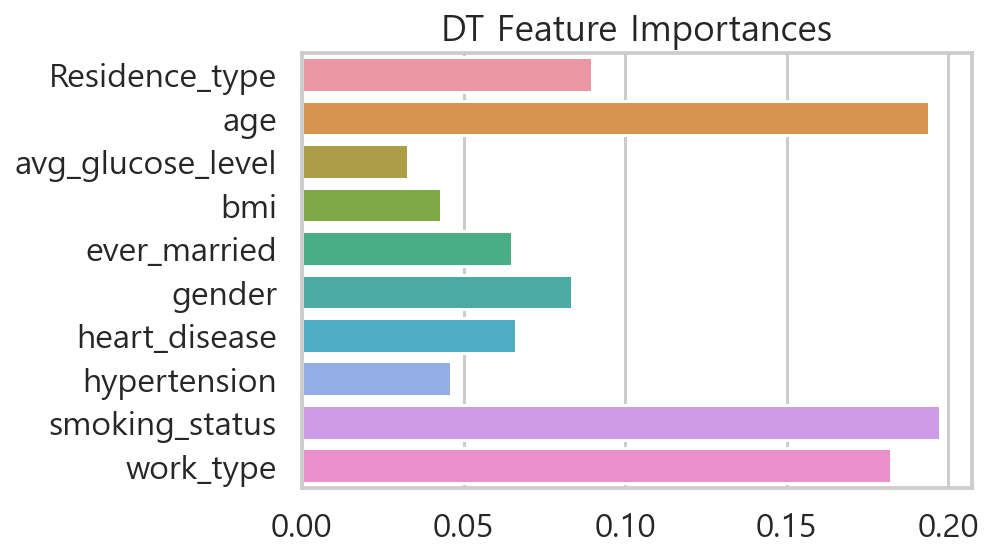

In [45]:
# 피처의 중요도 시각화 하기
plt.title('DT Feature Importances')
sns.barplot(x = best_est.feature_importances_, y = df.columns.difference(['stroke']))
plt.show()